In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import datetime as dt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller
import os
import sklearn.metrics as sk_m
from sklearn import linear_model
from sklearn.decomposition import PCA
os.environ["NUMBER_OF_PROCESSORS"] = "2"
import seaborn as sns; sns.set(color_codes=True)
import plotly.plotly as ply
%matplotlib inline

In [2]:
def gather_data(filename, sheet):
    df = pd.read_excel(filename,sheetname=sheet)
    #drop columns where all the values are na
    df = df.dropna(axis = 1, how = 'all')
    #naming the columns properly
    return df

def process_headers(df):
    df = df.copy()
    curr_colnames = list(df.columns)
    colnames =list(df.loc[0,:])
    for i,col in enumerate(list(curr_colnames)):
        if col.find("Unnamed") != -1:
            curr_colnames[i] = curr_colnames[i-1]
            col = curr_colnames[i-1]
        colnames[i]= str(col) + '__'+str(colnames[i]) 
    df.columns = colnames
    df = df.loc[1:,:]
    return df
        
def process_timeline(df):
    #aligns the dataframe with single timeline
    #break the dataframe into separate dataframes with regards to timelines
    df_dict = {}
    count_dates = [0 if x.lower().find('date')==-1 else 1 for x in list(df.columns)]
    
    ct_df = 0
    start = 0
    start_index = 0
    for i,dt in enumerate(count_dates):
        if dt == 1 and start ==0:
            df_dict[ct_df] = pd.DataFrame()
            start_index = i
            start = 1
            
        elif dt ==1:
            df_dict[ct_df] = df.iloc[:,start_index:i]
            ct_df = ct_df + 1
            start_index = i
            
        elif i == len(count_dates) - 1 and start == 1:
            df_dict[ct_df] = df.iloc[:,start_index:]
            start = 0
    
    for key in sorted(list(df_dict.keys())):
        temp_df = df_dict[key].copy()
        temp_df = temp_df.loc[temp_df.iloc[:,0].dropna().index,:]
        temp_df.index = temp_df.iloc[:,0]
        temp_df = temp_df.iloc[:,1:]
        df_dict[key] = temp_df
        
    #merging the dataframes together
    total_df = np.nan
    for i,key in enumerate(sorted(list(df_dict.keys()))):
        if i == 0:
            total_df =df_dict[key]
        else:
            #print key, df_dict[key].head()
            total_df = total_df.merge(df_dict[key],left_index = True, right_index = True, how = 'outer')
    return total_df
    pass


In [11]:
def trade_calc(df, securities):
    #calculates the flies on 1-2-1 basis and gets the time-series of the fly
    pass
    if len(securities)==2:
        return -1*(df[securities[0]])+1*(df[securities[1]])
    return -1*(df[securities[0]]) + 2*(df[securities[1]]) + -1*(df[securities[2]])

def o_trade_calc(df, securities):  #This just returns time series of the belly * 1
    pass
    if len(securities)==2:
        return -0*(df[securities[0]])+1*(df[securities[1]])
    return -0*(df[securities[0]]) + 1*(df[securities[1]]) + -0*(df[securities[2]])

def trade_pca_calc(df, securities):
    temp_df = df[securities].dropna()
    
    X = np.array((temp_df[securities]-temp_df.shift(1)[securities]).dropna())
    pca_model = PCA()
    pca_model.fit(X)
    weights = pca_model.components_[len(securities)-1,:]    
    if len(securities)==2:
        weights = weights/weights[1]
        #print weights
        return weights[0]*df[securities[0]]+weights[1]*df[securities[1]]
    
    #print "Weights of PCA Butterfly"
    #print weights

    weights = weights/weights[1]*2.
    #print weights
    return weights[0]*df[securities[0]]+weights[1]*df[securities[1]]+weights[2]*df[securities[2]]
    pass

def rolling_pca_calc(df, securities, window):
    full_temp_df = df[securities].dropna()
    rolling_pca = pd.DataFrame(columns = securities, index = full_temp_df.index)
    use_index = rolling_pca.index 
    for i, ind in enumerate(use_index[window:]):
        temp_df = full_temp_df.loc[use_index[i]:ind,securities].dropna()
        X = np.array((temp_df[securities]-temp_df.shift(1)[securities]).dropna())
        pca_model = PCA()
        pca_model.fit(X)
        weights = pca_model.components_[len(securities)-1,:]
        weights = weights/weights[1]
        rolling_pca.loc[ind,:] = weights.tolist()
    
    return rolling_pca
    

#mean reversion equation - dxt = a(b-xt-1) + error


def mean_reversion(flies):
    # Returns mean reversion characteristics for fly entered
    # Xt - X(t-1) = alpha*(theta - X(t-1)) + sigma*N(0,1)
    model_gaussian = linear_model.LinearRegression()
    dt_flies = flies - flies.shift(1)
    X = np.array(flies.shift(1).dropna()).reshape((-1,1))
    Y = np.array(dt_flies.dropna()).reshape((-1,1))
    model_gaussian.fit(X = X, y=Y)
    alpha = model_gaussian.coef_[0]*-1.
    theta = model_gaussian.intercept_/alpha
    r_squared = sk_m.r2_score(np.array(flies).reshape((-1,1))[1:],X+model_gaussian.predict(X))
    #r_squared = sk_m.r2_score(Y,model_gaussian.predict(X))
    return list(alpha)[0], list(theta)[0], r_squared
    # Log(2)/alpha is the half life of the trade
    # Theta is the long term average
    # Trade idea will be displacement (Current value - Theta)/alpha - metric and compare against sigma for z-score
    pass
    

In [3]:
filename = r'/Users/Abhishek/Global_macro/Datafin_orig.xlsx'
#test_frame = pd.read_excel(filename, sheet = 'Data-SwapRates')

In [4]:
test_frame = gather_data(filename,'Data-Bonds')
ret_frame = process_headers(test_frame)

In [12]:
ret_df = process_timeline(ret_frame)

In [6]:
ret_df.head()

,OBL 1 02/22/19 168 Govt__YLD_YTM_MID,OBL 1 02/22/19 168 Govt__Z_SPRD_MID,OBL 1 02/22/19 168 Govt__O_SPREAD_MID,OBL 1 02/22/19 168 Govt__BB_OIS_MMS_OIS_DISC_MID,OBL 1 02/22/19 168 Govt__O_SPREAD_BID,OBL 1 02/22/19 168 Govt__O_SPREAD_ASK,OBL 1 02/22/19 168 Govt__Z_SPRD_ASK,OBL 1 02/22/19 168 Govt__Z_SPRD_BID,DBR 3.25 01/04/20 09 Govt__YLD_YTM_MID,DBR 3.25 01/04/20 09 Govt__Z_SPRD_MID,...,T 5 05/15/37 Govt__Z_SPRD_ASK,T 5 05/15/37 Govt__Z_SPRD_BID,gt30 govt__YLD_YTM_MID,gt30 govt__Z_SPRD_MID,gt30 govt__O_SPREAD_MID,gt30 govt__BB_OIS_MMS_OIS_DISC_MID,gt30 govt__O_SPREAD_BID,gt30 govt__O_SPREAD_ASK,gt30 govt__Z_SPRD_ASK,gt30 govt__Z_SPRD_BID
2015-03-09 00:00:00,-0.17,-40.832,-13.595,-13.692,-11.03,-16.159,NaN,NaN,-0.131,-43.449,...,NaN,NaN,2.798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-10 00:00:00,-0.197,-41.19,-13.94,-14.154,-11.306,-16.549,NaN,NaN,-0.16,-41.925,...,NaN,NaN,2.723,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-11 00:00:00,-0.198,-38.91,-12.317,-12.626,-9.687,-14.923,NaN,NaN,-0.162,-39.319,...,NaN,NaN,2.686,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-12 00:00:00,-0.179,-37.457,-13.178,-13.054,-10.576,-15.805,NaN,NaN,-0.136,-38.949,...,NaN,NaN,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-13 00:00:00,-0.172,-36.802,-12.077,-12.466,-9.528,-14.625,NaN,NaN,-0.126,-38.317,...,NaN,NaN,2.699,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Assign Names to columns
#For Sheet - Data-SwapRates
#assign_dict = {x:y for x,y in zip(range(len(ret_df.columns),[]))}
#print ret_df.tail()
#print map(list(ret_df.columns).__getitem__,[2,4,6])
#pca_fly_us_2510 = trade_pca_calc(ret_df,map(list(ret_df.columns).__getitem__,[2,4,6]))
#fly_list = ['BPSW3 Curncy','BPSW5 Curncy','BPSW7 Curncy']; fly_list = [x+'__PX_LAST' for x in fly_list]
#fly_index = [list(ret_df.columns).index(x) for x in fly_list]
#pca_fly_eusa_2510 = fly_pca_calc(ret_df,map(list(ret_df.columns).__getitem__,fly_index))

In [7]:
#Header lookup
filename_headers = r'/Users/Abhishek/Global_macro/Datafin.xlsx'
headers = pd.read_excel(filename_headers,sheetname='Sheet 31')
headers.index = headers.iloc[:,0]
headers = headers.iloc[:,1:]
headers

,GER,NET,FIN,AUT,FRA,BEL,IRE,ESP,ITL,PTE,UKT
TENOR,,,,,,,,,,,
2Y,OBL 1 02/22/19 168,NETHER 4 07/15/19,RFGB 4.375 07/04/19,RAGB 4.35 03/15/19,FRTR 1 05/25/19,BGB 4 03/28/19 55,IRISH 4.5 10/18/18,SPGB 2.75 04/30/19,BTPS 2.5 05/01/19,PGB 4.75 06/14/19,UKT 1.75 07/22/19
3Y,DBR 3.25 01/04/20 09,NETHER 3.5 07/15/20,RFGB 3.375 04/15/20,RAGB 3.9 07/15/20,FRTR 0 05/25/20,BGB 3.75 09/28/20 58,IRISH 5.9 10/18/19,SPGB 4 04/30/20,BTPS 0.7 05/01/20,PGB 4.8 06/15/20,UKT 2 07/22/20
5Y,DBR 2 01/04/22,NETHER 2.25 07/15/22,RFGB 1.625 09/15/22,RAGB 3.65 04/20/22,FRTR 3.25 10/25/21,BGB 4.25 09/28/22 65,IRISH 0.8 03/15/22,SPGB 5.85 01/31/22,BTPS 5 03/01/22,PGB 2.2 10/17/22,UKT 0.5 07/22/22
7Y,DBR 1.75 02/15/24,NETHER 2 07/15/24,RFGB 2 04/15/24,RAGB 1.65 10/21/24 1,FRTR 2.25 05/25/24,BGB 2.6 06/22/24 72,IRISH 3.4 03/18/24,SPGB 3.8 04/30/24,BTPS 4.5 03/01/24,PGB 5.65 02/15/24,UKT 2.75 09/07/24
10Y,DBR 0.5 02/15/26,NETHER 0.5 07/15/26,RFGB 0.5 04/15/26,RAGB 0.75 10/20/26,FRTR 0.5 05/25/26,BGB 1 06/22/26 77,IRISH 1 05/15/26,SPGB 1.95 04/30/26,BTPS 4.5 03/01/26,PGB 2.875 07/21/26,UKT 4.25 12/07/27
15Y,DBR 4.75 07/04/34 ++03,NETHER 2.5 01/15/33,RFGB 0.75 04/15/31,RAGB 2.4 05/23/34,FRTR 5.75 10/25/32,BGB 4 03/28/32 66,IRISH 2.4 05/15/30,SPGB 5.75 07/30/32,BTPS 1.65 03/01/32,PGB 3.875 02/15/30,UKT 4.25 06/07/32
20Y,DBR 4 01/04/37 ++05,NETHER 4 01/15/37,#N/A Invalid Security,RAGB 4.15 03/15/37,FRTR 4 10/25/38,BGB 1.9 06/22/38 76,#N/A Invalid Security,SPGB 4.2 01/31/37,BTPS 4 02/01/37,PGB 4.1 04/15/37,UKT 4.25 03/07/36
30Y,DBR 2.5 08/15/46,NETHER 2.75 01/15/47,RFGB 2.625 07/04/42,RAGB 1.5 02/20/47,FRTR 3.25 05/25/45,BGB 1.6 06/22/47 78,IRISH 2 02/18/45,SPGB 2.9 10/31/46,BTPS 3.25 09/01/46,PGB 4.1 02/15/45,UKT 1.5 07/22/47


In [13]:
#Part 1 - All Fly Structures - PCA and 1-2-1 - all countries and butterfly structures - YTM

fly_list_master = [[2, 5, 10],[3,5,7],[5,7,10],[2, 5, 30], [5, 10, 15], [2, 10, 30], [5, 10, 30]]
fly_list_str = ['FLY'+''.join([str(y) for y in x]) for x in fly_list_master]
pca_metrics_df_dict = {key:pd.DataFrame(columns = headers.columns, index = fly_list_str) 
                       for key in ['Current Displacement', 'Relative Displacement', 'R-squared','Half-life']}
metrics_df_dict = {key:pd.DataFrame(columns = headers.columns, index = fly_list_str) 
                   for key in ['Current Displacement', 'Relative Displacement', 'R-squared','Half-life']}

import matplotlib.pyplot as plt
plt.style.use('ggplot')

fly_country_dict = {key:np.nan for key in list(headers.columns)}
pca_fly_country_dict = {key:np.nan for key in list(headers.columns)}


for ind1 , fly_list in enumerate(fly_list_master):
    str_list = 'FLY'+''.join([str(x) for x in fly_list])
    for country in fly_country_dict.keys()[:]:
        tickerlist = [headers.loc[str(x)+'Y',country] for x in fly_list]
        metric = 'YLD_YTM_MID'
        tickerlist = [x+' Govt__'+metric for x in tickerlist]

        pca_fly_country_dict[country] = pd.DataFrame(trade_pca_calc(ret_df,tickerlist).dropna(), columns = ['PCA_Fly'+''.join([str(x) for x in fly_list])])
        fly_country_dict[country] = pd.DataFrame(trade_calc(ret_df,tickerlist).dropna(),columns = ['1-2-1_Fly'+''.join([str(x) for x in fly_list])])
        '''
        ax = pca_fly_country_dict[country].plot(legend = True)
        fly_country_dict[country].plot(legend = True, ax = ax)
        plt.show()'''
        (alpha, theta, r_squared) = mean_reversion(pca_fly_country_dict[country])
        pca_metrics_df_dict['Current Displacement'].loc[str_list, country]=(theta - float(pca_fly_country_dict[country].iloc[-1,:]))
        relative_distance = (theta - float(pca_fly_country_dict[country].iloc[-1,:]))/theta
        pca_metrics_df_dict['Relative Displacement'].loc[str_list, country]=relative_distance
        pca_metrics_df_dict['R-squared'].loc[str_list, country]=r_squared
        pca_metrics_df_dict['Half-life'].loc[str_list, country]=np.log(2)/alpha           

        (alpha, theta, r_squared) = mean_reversion(fly_country_dict[country])
        metrics_df_dict['Current Displacement'].loc[str_list, country]=(theta - float(fly_country_dict[country].iloc[-1,:]))
        relative_distance = (theta - float(fly_country_dict[country].iloc[-1,:]))/theta
        metrics_df_dict['Relative Displacement'].loc[str_list, country]=relative_distance
        metrics_df_dict['R-squared'].loc[str_list, country]=r_squared
        metrics_df_dict['Half-life'].loc[str_list, country]=np.log(2)/alpha           

            
            #axes = sns.tsplot(pca_fly_country_dict[country].dropna())
            #axes1 = sns.tsplot(fly_country_dict[country].dropna())
            #plt.legend([axes.plot,axes1.plot],[country+'pca',country+'1-2-1'])



/Users/Abhishek/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



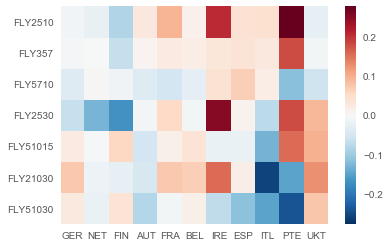

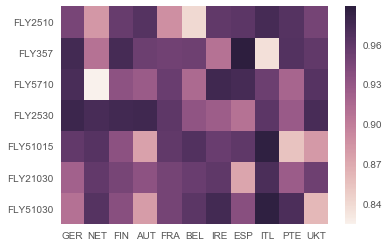

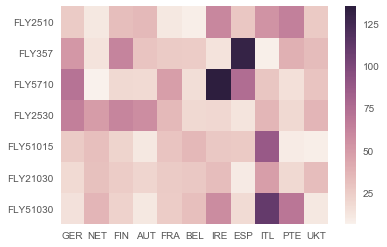

In [14]:
import seaborn as sns
sns.heatmap(pca_metrics_df_dict['Current Displacement'].astype(float));plt.show()
sns.heatmap(pca_metrics_df_dict['R-squared'].astype(float));plt.show()
sns.heatmap(pca_metrics_df_dict['Half-life'].astype(float));plt.show()

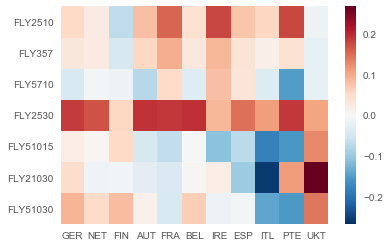

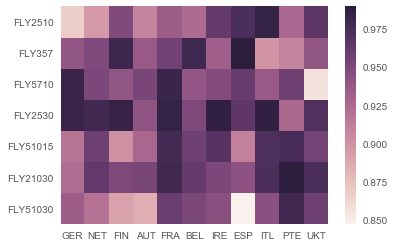

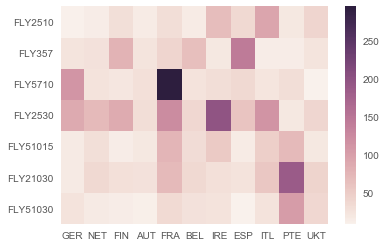

In [15]:
import seaborn as sns
sns.heatmap(metrics_df_dict['Current Displacement'].astype(float));plt.show()
sns.heatmap(metrics_df_dict['R-squared'].astype(float));plt.show()
sns.heatmap(metrics_df_dict['Half-life'].astype(float));plt.show()

In [16]:
#Intra-Country flies regressions for both PCA and 1-2-1 weighted flies

def realign_dates(df_list):
    df_list = [pd.DataFrame(x) for x in df_list]
    master_df = df_list[0]
    for x in df_list[1:]:
        master_df = master_df.merge(x, how = 'outer', left_index = True, right_index = True)
    
    master_df = master_df.dropna()
    df_list = [master_df[col] for col in master_df.columns]
    return df_list
    
def ret_regression(ret_df,Ylist,Y_country,Xlist,X_country, metric = 'YLD_YTM_MID', del_changes = True):
    
    print metric
    ds1 = Y_country
    ds2 = X_country
    Y_tickerlist = [headers.loc[str(x)+'Y',Y_country]+' Govt__'+metric for x in Ylist]
    X_tickerlist = [headers.loc[str(x)+'Y',X_country]+' Govt__'+metric for x in Xlist]
    
    Y_country = Y_country+''.join([str(x) for x in  Ylist])
    X_country = X_country+''.join([str(x) for x in Xlist])
    
    if Y_country == X_country:
        print "Regression Not Possible"
        return 0.
    
    fly_country_dict = {key:np.nan for key in [Y_country,X_country]}
    pca_fly_country_dict = {key:np.nan for key in [Y_country,X_country]}
    

    try:
        print Y_country+' PCA_Fly Weights'
        pca_fly_country_dict[Y_country] = pd.DataFrame(trade_pca_calc(ret_df,Y_tickerlist).dropna()
                                                       , columns = [Y_country+'PCA_Fly'])
        print X_country+' PCA_Fly Weights'
        pca_fly_country_dict[X_country] = pd.DataFrame(trade_pca_calc(ret_df,X_tickerlist).dropna()
                                                       , columns = [X_country+'PCA_Fly'])
        
        fly_country_dict[Y_country] = pd.DataFrame(trade_calc(ret_df,Y_tickerlist).dropna()
                                                   ,columns = [Y_country+'1-2-1_Fly'])
        fly_country_dict[X_country] = pd.DataFrame(trade_calc(ret_df,X_tickerlist).dropna()
                                                   ,columns = [X_country+'1-2-1_Fly'])
        
    except:
        print "Did not work at data referencing level"
        return 0.
    if del_changes:
        lm = sk.linear_model.LinearRegression(fit_intercept=False)
        lm_1= sk.linear_model.LinearRegression(fit_intercept=False)
        # We want to fit the model Del Fly1 ~ Del Fly2
        
        
        
        print 'Regression time series'
        plt.show()
        Y = pca_fly_country_dict[Y_country] - pca_fly_country_dict[Y_country].shift(1)
        Y = Y.dropna()
        X = pca_fly_country_dict[X_country] - pca_fly_country_dict[X_country].shift(1)
        X = X.dropna()
        input_list = realign_dates([Y,X])
        Y = np.array(input_list[0]).reshape((-1,1)); X = np.array(input_list[1]).reshape((-1,1))
        
        
        Yp = pca_fly_country_dict[Y_country] #
        Xp = pca_fly_country_dict[X_country] #
        
       
        
        #model = sm.OLS(Y,X,hasconst = True)
        #results = model.fit()
        lm.fit(X = X, y = Y)
        
        Y_1 = fly_country_dict[Y_country] - fly_country_dict[Y_country].shift(1)
        Y_1 = Y_1.dropna()
        X_1 = fly_country_dict[X_country] - fly_country_dict[X_country].shift(1)
        X_1 = X_1.dropna()
        
        
        Yp1 = fly_country_dict[Y_country] #
        Xp1 = fly_country_dict[X_country] # 
        
       
        
        input_list = realign_dates([Y_1,X_1])
        Y_1 = np.array(input_list[0]).reshape((-1,1)); X_1 = np.array(input_list[1]).reshape((-1,1))
        lm_1.fit(X =X_1,y=Y_1)
        #return results
        if (abs(lm.coef_[0][0])> 0.6) and (abs(lm_1.coef_[0][0])> 0.6):
            print('\x1b[6;30;42m' + 'High Beta' + '\x1b[0m')
        return {'PCA':{'beta':lm.coef_[0][0], 'r2-score':sk_m.r2_score(Y,lm.predict(X))},
                '1-2-1':{'beta':lm_1.coef_[0][0], 'r2-score':sk_m.r2_score(Y_1,lm_1.predict(X_1))}}
    else:
        lm = sk.linear_model.LinearRegression()
        Y = pca_fly_country_dict[Y_country]
        X = pca_fly_country_dict[X_country]
        input_list = realign_dates([Y,X])
        Y = np.array(input_list[0]).reshape((-1,1)); X = np.array(input_list[1]).reshape((-1,1))
        lm.fit(X = X, y = Y)
        return {'beta':lm.coef_[0][0], 'intercept':lm.intercept_[0][0],'r2-score':sk_m.r2_score(Y,lm.predict(X))}



In [17]:
# Regression of curves vs the outrights levels of rates
import statsmodels.formula as smf
import statsmodels.tsa as smt
import statsmodels as sm
import scipy.stats as scs
import statsmodels.tsa.stattools as tools

def tsdiagnostics(y, lags=None, figsize=(10, 8), style='ggplot'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        y = y.dropna()

    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        #pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        acf_mod = tools.acf(y,nlags = 40)
        acf_ax.bar(range(41), acf_mod, width = 0.5,color='r')
        acf_ax.set_title('ACF')
        sm.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.graphics.gofplots.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')  
        plt.show()
        #scs.probplot(np.array(y).ravel(), plot=pp_ax)#, sparams=(y.mean(), y.std())
        
        print 'ADF Tests'
        adf_test = adfuller(np.array(y), regression='c', autolag='AIC', store=False, regresults=False)
        
        print('ADF Statistic: %f' % adf_test[0])
        print('p-value: %f' % adf_test[1])
        print('Critical Values:')
        for key, value in adf_test[4].items():
            print('\t%s: %.3f' % (key, value))
        
        #hurst_exponent = 0.
        (alpha, theta, r_squared) = mean_reversion(y)
        #print y
        #print type(y)
        ynew = y.to_frame()
        #print ynew
        #print type(ynew)
        print 'Mean Reversion characteristics'
        print {'half-life':np.log(2)/alpha,'Average':theta
               ,'Current_Displacement':theta - float(ynew.iloc[-1,:])
               , 'R-squared':r_squared}
        
    #return adf_test

In [18]:
def portfolio_regression(ret_df,Ylist,Yweights,Y_country,Xlist,Xweights,X_country
                         , metric = 'YLD_YTM_MID', del_changes = True):
    if not isinstance(Y_country,list):
        Y_country = [Y_country]*len(Yweights)
    if not isinstance(X_country,list):
        X_country = [X_country]*len(Xweights)
        
    Y_tickerlist = [headers.loc[str(x)+'Y',country]+' Govt__'+metric for x,country in zip(Ylist,Y_country)]
    X_tickerlist = [headers.loc[str(x)+'Y',country]+' Govt__'+metric for x,country in zip(Xlist,X_country)]
    Y_country_label = ','.join([country+'_'+str(x) for x,country in  zip(Ylist,Y_country)])
    X_country_label = ','.join([country+'_'+str(x) for x,country in  zip(Xlist,X_country)])
    
   

    try:
        Y = pd.DataFrame(np.array(sum([ret_df[col]*weight for col,weight in zip(Y_tickerlist,Yweights)]))
                                                       , columns = [Y_country_label+'_portfolio_trade'])
        Y = Y.dropna()
        X = pd.DataFrame(np.array(sum([ret_df[col]*weight for col,weight in zip(X_tickerlist,Xweights)]))
                                                       , columns = [X_country_label+'_portfolio_trade'])
        X = X.dropna()
        
    except:
        print "Did not work at data referencing level"
        return 0.
    
    ax = Y.plot(legend = True)
    X.plot(legend = True, ax = ax)
    print 'Regression time series'
    plt.show()
    
    if del_changes:
        lm = sk.linear_model.LinearRegression(fit_intercept=False)
        # We want to fit the model Del Fly1 ~ Del Fly2
        
        Y = Y - Y.shift(1)
        Y = Y.dropna()
        X = X - X.shift(1)
        X = X.dropna()
        input_list = realign_dates([Y,X])
        Y = np.array(input_list[0]).reshape((-1,1)); X = np.array(input_list[1]).reshape((-1,1))
        
        
        
        
        
        #model = sm.OLS(Y,X,hasconst = True)
        #results = model.fit()
        lm.fit(X = X, y = Y)
        residuals = Y - lm.predict(X)
        residuals = residuals.reshape(-1)
        tsdiagnostics(residuals)
        plt.scatter(x=X,y=Y)
        plt.plot(X,np.array(lm.coef_).ravel()[0]*X , 'b')
        plt.show()
        return {'beta':np.array(lm.coef_).ravel(), 'r2-score':sk_m.r2_score(Y,lm.predict(X))}
    
    else:
        lm = sk.linear_model.LinearRegression()
        input_list = realign_dates([Y,X])
        Y = np.array(input_list[0]).reshape((-1,1)); X = np.array(input_list[1]).reshape((-1,1))
        lm.fit(X = X, y = Y)
        return {'beta':lm.coef_[0][0], 'intercept':lm.intercept_[0][0],'r2-score':sk_m.r2_score(Y,lm.predict(X))}

def ret_custom_portfolio(ret_df,Ylist,Yweights,Y_country
                         , metric = 'YLD_YTM_MID', del_changes = True):
    Y_tickerlist = [headers.loc[str(x)+'Y',Y_country]+' Govt__'+metric for x in Ylist]
    
    Y_country = Y_country+''.join([str(x) for x in  Ylist])
    
    try:
        cust_portfolio = pd.DataFrame(sum([ret_df[col]*weight for col,weight in zip(Y_tickerlist,Yweights)])
                                                       , columns = [Y_country+'_portfolio_trade'])
        cust_portfolio = cust_portfolio.dropna()
    except:
        print "Did not work at data referencing level"
        return 0.
    return cust_portfolio

In [19]:
# Part 2 
mastercurve_list = [[2,5],[2,7],[2,10],[5,10],[5,15],[7,15],[2,30],[5,30],[10,30]]
#curve_list = [5,10]
import matplotlib.pyplot as plt
curve_list_str = ['Curve'+''.join([str(y) for y in x]) for x in mastercurve_list]
curve_pca_metrics_df_dict = {key:pd.DataFrame(columns = headers.columns, index = curve_list_str) 
                       for key in ['Current Displacement', 'Relative Displacement', 'R-squared','Half-life']}
curve_metrics_df_dict = {key:pd.DataFrame(columns = headers.columns, index = curve_list_str) 
                   for key in ['Current Displacement', 'Relative Displacement', 'R-squared','Half-life']}
plt.style.use('ggplot')
curve_country_dict = {key:np.nan for key in list(headers.columns)}
pca_curve_country_dict = {key:np.nan for key in list(headers.columns)}
for country in list(headers.columns)[:]:
    for curve_list in mastercurve_list:
        str_list = 'Curve'+''.join([str(y) for y in curve_list])
        tickerlist = [headers.loc[str(x)+'Y',country] for x in curve_list]
        metric = 'YLD_YTM_MID'
        tickerlist = [x+' Govt__'+metric for x in tickerlist]
        #try:
        pca_curve_country_dict[country] = pd.DataFrame(trade_pca_calc(ret_df,tickerlist).dropna()
                                                       , columns = ['PCA_Curve'+''.join([str(x) for x in curve_list])])
        curve_country_dict[country] = pd.DataFrame(trade_calc(ret_df,tickerlist).dropna()
                                                   ,columns = ['1-1_Curve'+''.join([str(x) for x in curve_list])])

        (alpha, theta, r_squared) = mean_reversion(pca_curve_country_dict[country])
        curve_pca_metrics_df_dict['Current Displacement'].loc[str_list, country]=(theta - float(pca_curve_country_dict[country].iloc[-1,:]))
        relative_distance = (theta - float(pca_curve_country_dict[country].iloc[-1,:]))/theta
        curve_pca_metrics_df_dict['Relative Displacement'].loc[str_list, country]=relative_distance
        curve_pca_metrics_df_dict['R-squared'].loc[str_list, country]=r_squared
        curve_pca_metrics_df_dict['Half-life'].loc[str_list, country]=np.log(2)/alpha           

        (alpha, theta, r_squared) = mean_reversion(curve_country_dict[country])
        curve_metrics_df_dict['Current Displacement'].loc[str_list, country]=(theta - float(curve_country_dict[country].iloc[-1,:]))
        relative_distance = (theta - float(curve_country_dict[country].iloc[-1,:]))/theta
        curve_metrics_df_dict['Relative Displacement'].loc[str_list, country]=relative_distance
        curve_metrics_df_dict['R-squared'].loc[str_list, country]=r_squared
        curve_metrics_df_dict['Half-life'].loc[str_list, country]=np.log(2)/alpha           


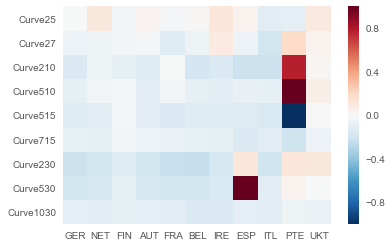

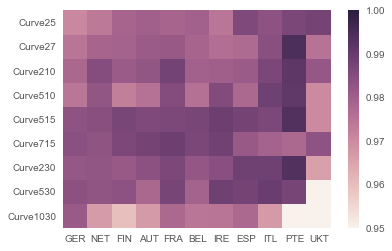

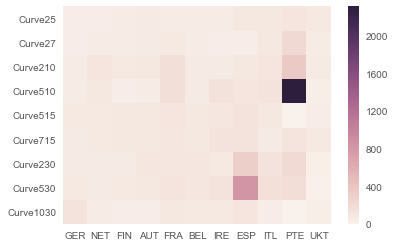

In [20]:
import seaborn as sns
sns.heatmap(curve_metrics_df_dict['Current Displacement'].astype(float),vmin=-1.,vmax=1.);plt.show()
sns.heatmap(curve_metrics_df_dict['R-squared'].astype(float),vmin=0.95,vmax=1.);plt.show()
sns.heatmap(curve_metrics_df_dict['Half-life'].astype(float), vmin=0.);plt.show()